In [14]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
seaborn.set_style("white")

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.read_csv('data/turnstile_180623.txt')
df2 = pd.read_csv('data/turnstile_180602.txt')
df1.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068


In [3]:
# df_alldata = pd.concat([df1,df2])

Check hierarchy of members

In [4]:
# df1.groupby(['STATION', 'UNIT', 'C/A'])['SCP'].unique().head(5)

Strip whitespace in columns

In [5]:
newcolumns = df1.columns.str.strip()
df1.columns = newcolumns

In [6]:
df1['DATETIME'] = df1['DATE'] + ' ' + df1['TIME']
df1['DATETIME'] = pd.to_datetime(df1['DATETIME'])
df1.sample(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
45697,N044,R187,00-00-01,81 ST-MUSEUM,BC,IND,06/19/2018,01:00:00,REGULAR,16264514,3149207,2018-06-19 01:00:00
176210,R510,R090,00-00-00,39 AV,NQW,BMT,06/22/2018,20:00:00,REGULAR,2451324,732473,2018-06-22 20:00:00
160484,R262A,R195,04-00-05,161/YANKEE STAD,4BD,IRT,06/18/2018,16:22:00,REGULAR,79155,61101,2018-06-18 16:22:00


In [7]:
df1['ENTRY_DIFFS'] = (df1
                      .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                      .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES']
                      .diff())
df1['EXIT_DIFFS'] = (df1
                     .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                     .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS']
                     .diff())

In [8]:
## check to make sure NaN appears for the first row for an SCP
df1[40:].head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS
40,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,16:00:00,REGULAR,6666235,2259814,2018-06-22 16:00:00,329.0,74.0
41,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,20:00:00,REGULAR,6666924,2259874,2018-06-22 20:00:00,689.0,60.0
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,5964171,1334598,2018-06-16 00:00:00,NaN,NaN
43,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,5964188,1334606,2018-06-16 04:00:00,17.0,8.0
44,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,5964202,1334630,2018-06-16 08:00:00,14.0,24.0


In [62]:
## purge values that don't make any sense in ENTRY_DIFFS and EXIT_DIFFS
df1.loc[df1['ENTRY_DIFFS'] < 0, 'ENTRY_DIFFS'] = 0
df1.loc[df1['ENTRY_DIFFS'] > 100000, 'ENTRY_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] < 0, 'EXIT_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] > 100000, 'EXIT_DIFFS'] = 0

In [104]:
## make series of weekly total SCP-entry_diffs and SCP-exit_diffs pairs
SCP_ENTRY_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRY_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRY_DIFFS']
                  .sum())
SCP_EXIT_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'EXIT_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXIT_DIFFS']
                  .sum())
SCP_ENTRY_weektotals.head(5)

STATION  UNIT  C/A   SCP     
1 AV     R248  H007  00-00-00    24023.0
                     00-00-01    31421.0
                     00-03-00     6240.0
                     00-03-01     4825.0
                     00-03-02     8038.0
Name: ENTRY_DIFFS, dtype: float64

(array([1871., 1302.,  806.,  429.,  174.,   75.,   33.,   10.,    8.,
           2.]),
 array([    0. ,  4524.3,  9048.6, 13572.9, 18097.2, 22621.5, 27145.8,
        31670.1, 36194.4, 40718.7, 45243. ]),
 <a list of 10 Patch objects>)

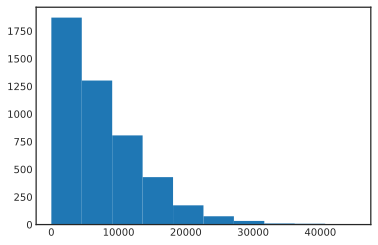

In [108]:
## histogram of SCP-entry totals for analysis
plt.hist(SCP_ENTRY_weektotals)

In [107]:
## display the highest-traffic stations for this week (all entries+ all exits)
STATION_traffic_weektotals = (SCP_ENTRY_weektotals + SCP_EXIT_weektotals).groupby(['STATION']).sum()
STATION_traffic_weektotals.sort_values(ascending=False).head(10)

STATION
34 ST-PENN STA     1868658.0
GRD CNTRL-42 ST    1711147.0
34 ST-HERALD SQ    1387533.0
14 ST-UNION SQ     1220524.0
TIMES SQ-42 ST     1218558.0
23 ST              1116914.0
FULTON ST          1078230.0
42 ST-PORT AUTH    1019479.0
86 ST               876680.0
125 ST              873321.0
dtype: float64